In [ ]:
# importing necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras import backend as K
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

Importing dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
train_path='/content/drive/MyDrive/ds3_project/DS-3 project-20221124T094233Z-001/DS-3 project'


Mounted at /content/drive


In [ ]:
# image width and heights
img_width=200
img_height=200   # choosing so

Checking Image Format

In [ ]:
if(K.image_data_format=='channels_first'):
  input_shape=(3,img_width,img_height)
else:
  input_shape=(img_width,img_height,3)  
  

In [ ]:
# data augmnetation and preprocessing using tensorflow
datagen_train=ImageDataGenerator(rescale=1./255. ,shear_range=0.2, zoom_range=0.2, horizontal_flip=True , validation_split=0.2)    #  training data =80% , validation_data=20%
train_generator=datagen_train.flow_from_directory(directory=train_path, subset='training' , color_mode='rgb' ,target_size=(img_width,img_height), batch_size=32, class_mode='categorical', shuffle=True, seed=42)
validation_generator=datagen_train.flow_from_directory(directory=train_path, subset='validation' ,color_mode='rgb' , target_size=(img_width,img_height), batch_size=32 , class_mode='categorical' , shuffle=True , seed=42)

Found 613 images belonging to 3 classes.
Found 151 images belonging to 3 classes.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (200,200,3) , 32: is the batch size

(32, 200, 200, 3)

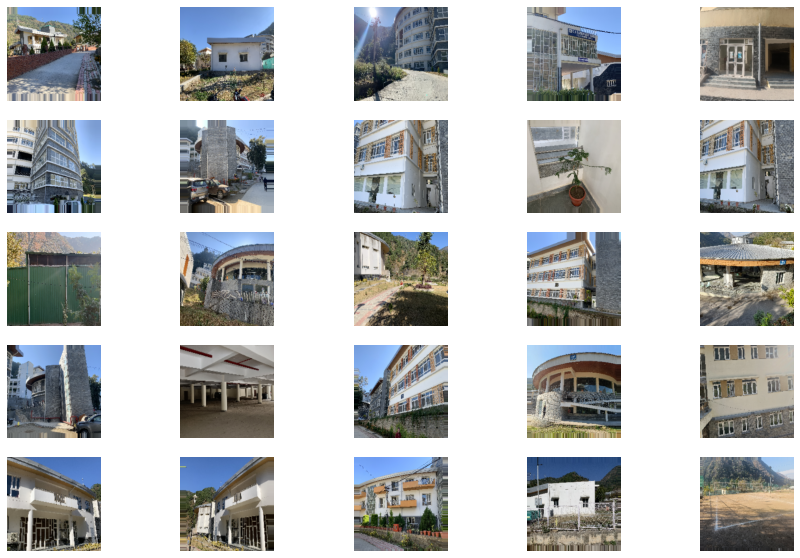

In [ ]:
# visualising train data
a=train_generator.class_indices
#print(list(a.keys))    # storing class

# function for plotting image
def plot_images(img,labels):
  plt.figure(figsize=[15,10])
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(img[i])
    plt.axis('off')

# plotting
plot_images(x,y)       

Building neural convulation

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, 
                                                   weights='imagenet',input_shape=(img_width,img_height,3))
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run

model=tf.keras.Sequential([base_model,
                           tf.keras.layers.BatchNormalization(renorm=True),
                           tf.keras.layers.GlobalAveragePooling2D(),
                           tf.keras.layers.Dense(512, activation='relu'),
                           tf.keras.layers.Dense(256, activation='relu'),
                           tf.keras.layers.Dropout(0.5),
                           tf.keras.layers.Dense(128, activation='relu'),
                           tf.keras.layers.Dense(3,activation='softmax')])   
# activation function relu for all except the last using softmax so as to make it slow
# buliding layers in above code
#The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped so as to avoid overfitting

Configure or compiling the model

In [ ]:
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
# displaying the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 4, 4, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
# defining the callbacks to preserve best results
early=tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

Training the model

In [ ]:
batch_size=32
step_size=613
step_size1=151
trained_model=model.fit_generator(train_generator,
                                  steps_per_epoch=step_size // batch_size,
                                  validation_data=validation_generator,
                                  validation_steps=step_size1 // batch_size,
                                  epochs=1,
                                  callbacks=[early])


19/19 [==============================] - 319s 16s/step - loss: 1.0704 - accuracy: 0.5766 - val_loss: 0.7723 - val_accuracy: 0.6719


In [ ]:
# saving the model
model.save("Model.h5")

Visualising model performance

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.5765920877456665\nValidation Accuracy: 0.671875')

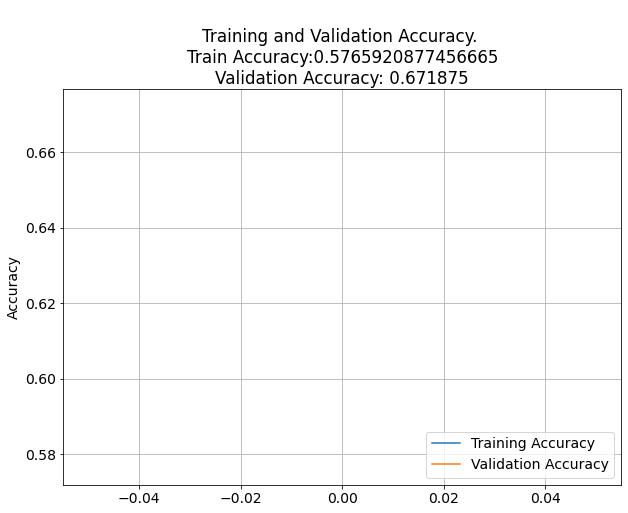

In [ ]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

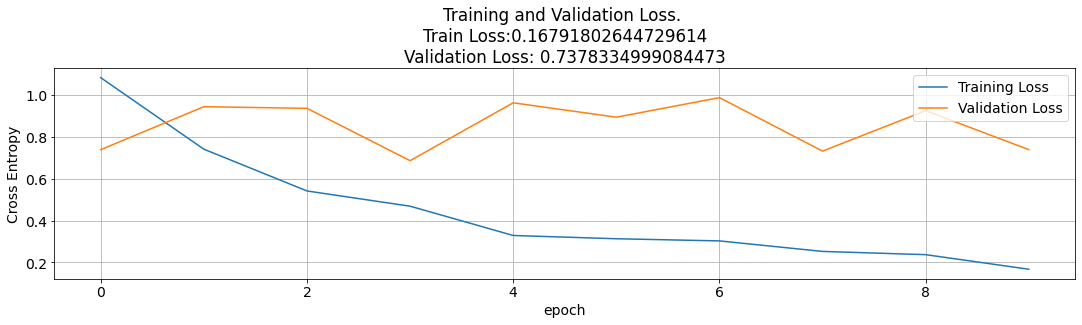

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Evaluating accuracy of the model
accuracy_score=model.evaluate(validation_generator)
print('Accuracy score')
print(accuracy_score[1])
print('Loss')
print(accuracy_score[0])

5/5 [==============================] - 57s 11s/step - loss: 0.8091 - accuracy: 0.6556
Accuracy score
0.6556291580200195
Loss
0.8090882897377014


Making prediction

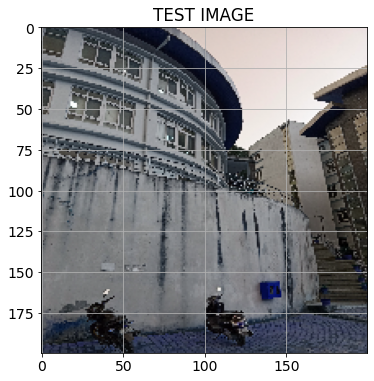

In [ ]:
test_img_path='/content/drive/MyDrive/IMG_20221121_165753_1.jpg'
'''
img=tf.keras.preprocessing.image.loag_img(test_img_path)
img=tf.keras.preprocessing.image.img_to_array(img)
img=tf.keras.preprocessing.image.smart_resize(img,(img_width,img_height))
img=tf.reshape(img,(-1,img_width,img_height,3))
'''
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (200, 200)).reshape(-1, 200, 200, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
# prediction
img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (200, 200))
img = tf.reshape(img, (-1, 200, 200, 3))
prediction = model.predict(img/255)

'''
predictions = []
 
for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))
 
my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)
 
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output
'''

prediction = model.predict(img/255)
prediction_final=np.argmax(prediction)
print(prediction_final)
choice=prediction_final



1/1 [==============================] - 5s 5s/step
1


Now we get to know the place where the photo was clicked now we will be working to know the building or other things present in the image.

Creating a function for training the required model

In [ ]:
# TRAINING North data
train_path_north='/content/drive/MyDrive/North_camp_final'
img_width_n=200
img_height_n=200   # choosing so
if(K.image_data_format=='channels_first'):
  input_shape=(3,img_width_n,img_height_n)
else:
  input_shape=(img_width_n,img_height_n,3)
# data augmnetation and preprocessing using tensorflow
datagen_train=ImageDataGenerator(rescale=1./255. ,shear_range=0.2, zoom_range=0.2, horizontal_flip=True , validation_split=0.2)    #  training data =80% , validation_data=20%
train_generator=datagen_train.flow_from_directory(directory=train_path_north, subset='training' , color_mode='rgb' ,target_size=(img_width,img_height), batch_size=32, class_mode='categorical', shuffle=True, seed=42)
validation_generator=datagen_train.flow_from_directory(directory=train_path_north, subset='validation' ,color_mode='rgb' , target_size=(img_width,img_height), batch_size=32 , class_mode='categorical' , shuffle=True , seed=42)  
 

Found 389 images belonging to 12 classes.
Found 91 images belonging to 12 classes.


In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(img_width_n,img_height_n,3))
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run
model=tf.keras.Sequential([base_model,
                          tf.keras.layers.BatchNormalization(renorm=True),
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(512, activation='relu'),
                          tf.keras.layers.Dense(256, activation='relu'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.Dense(128, activation='relu'),
                          tf.keras.layers.Dense(12,activation='softmax')])   
  # activation function relu for all except the last using softmax so as to make it slow
  # buliding layers in above code
  #The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped so as to avoid overfitting
  # categorical cross entropy is taken since its used as a loss function for
  # multi-class classification problems where there are two or more output labels.
  # using Adam optimizer for better performance
  # other optimizers such as sgd can also be used depending upon the model

model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['accuracy'], run_eagerly=True)
  # defining the callbacks to preserve best results 

In [ ]:
early=tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
batch_size=32
step_size_n=389//batch_size
validation_step= 91//batch_size # if you have validation data
trained_model=model.fit_generator(train_generator,
                                   steps_per_epoch=step_size_n,
                                   validation_data=validation_generator,
                                   validation_steps=validation_step,
                                   epochs=1,
                                   callbacks=[early])
model.save("Model_sub_north.h5")
  

12/12 [==============================] - 456s 38s/step - loss: 2.4650 - accuracy: 0.3165 - val_loss: 1.8617 - val_accuracy: 0.4531


In [ ]:
# training south data
train_path_south='/content/drive/MyDrive/south_camp_final'
img_width_n=200
img_height_n=200   # choosing so
if(K.image_data_format=='channels_first'):
  input_shape=(3,img_width_n,img_height_n)
else:
  input_shape=(img_width_n,img_height_n,3)
# data augmnetation and preprocessing using tensorflow
datagen_train=ImageDataGenerator(rescale=1./255. ,shear_range=0.2, zoom_range=0.2, horizontal_flip=True , validation_split=0.2)    #  training data =80% , validation_data=20%
train_generator=datagen_train.flow_from_directory(directory=train_path_south, subset='training' , color_mode='rgb' ,target_size=(img_width,img_height), batch_size=32, class_mode='categorical', shuffle=True, seed=42)
validation_generator=datagen_train.flow_from_directory(directory=train_path_south, subset='validation' ,color_mode='rgb' , target_size=(img_width,img_height), batch_size=32 , class_mode='categorical' , shuffle=True , seed=42)  

Found 218 images belonging to 25 classes.
Found 45 images belonging to 25 classes.


In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(img_width_n,img_height_n,3))
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run
model=tf.keras.Sequential([base_model,
                          tf.keras.layers.BatchNormalization(renorm=True),
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(512, activation='relu'),
                          tf.keras.layers.Dense(256, activation='relu'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.Dense(128, activation='relu'),
                          tf.keras.layers.Dense(25,activation='softmax')])   
  # activation function relu for all except the last using softmax so as to make it slow
  # buliding layers in above code
  #The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped so as to avoid overfitting
  # categorical cross entropy is taken since its used as a loss function for
  # multi-class classification problems where there are two or more output labels.
  # using Adam optimizer for better performance
  # other optimizers such as sgd can also be used depending upon the model

model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['accuracy'])
  # defining the callbacks to preserve best results 


In [ ]:
early=tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
batch_size=32
step_size=218 // batch_size
step_size1=45 // batch_size
trained_model=model.fit_generator(train_generator,
                                   steps_per_epoch=step_size,
                                   validation_data=validation_generator,
                                   validation_steps=step_size1,
                                   epochs=1,
                                   callbacks=[early])
model.save("Model_sub_south.h5")


6/6 [==============================] - 125s 19s/step - loss: 3.4746 - accuracy: 0.0645 - val_loss: 2.8037 - val_accuracy: 0.1250


Using retinnet to detect object in a image

In [ ]:
# installing pytorch retinanet
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     |████████████████████████████████| 510 kB 4.9 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 829 kB 43.3 MB/s 
     |████████████████████████████████| 117 kB 46.7 MB/s 
Found existing installation: torchtext 0.13.1
Uninstalling torchtext-0.13.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchtext-0.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchtext/*
Proceed (y/n)? y
  Successfully uninstalled torchtext-0.13.1
Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 2137 (delta 56), reused 32 (delta 15), pack-reused 2032
Receiving objects: 100% (2137/2137), 84.65 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (1406/1406), done.


In [ ]:
# include sys path to include pytorch retinanet library
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append('/content/pytorch_retinanet')
%load_ext autoreload
%autoreload 2

In [ ]:
# installing imageai library
!pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.1/imageai-2.0.1-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 2.8 MB/s 


In [ ]:
from imageai.Detection import ObjectDetection  # importing object detection from image ai
import os

execution_path = os.getcwd()

In [ ]:
!pip install tensorflow numpy scipy pillow matplotlib h5py keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
detector= ObjectDetection()
model_path='/content/Model_sub_north.h5'
#detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_path)
detector.setModelTypeAsRetinaNet()
'''

"\ndetector= ObjectDetection()\nmodel_path='/content/Model_sub_north.h5'\n#detector.setModelTypeAsYOLOv3()\ndetector.setModelPath(model_path)\ndetector.setModelTypeAsRetinaNet()\n"

In [ ]:
'''
# loading model
detector.loadModel()
'''

'\n# loading model\ndetector.loadModel()\n'

In [ ]:
test_img_path='/content/drive/MyDrive/IMG_20221121_165753_1.jpg'
'''
img=tf.keras.preprocessing.image.loag_img(test_img_path)
img=tf.keras.preprocessing.image.img_to_array(img)
img=tf.keras.preprocessing.image.smart_resize(img,(img_width,img_height))
img=tf.reshape(img,(-1,img_width,img_height,3))
'''
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (200, 200)).reshape(-1, 200, 200, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])


In [ ]:
if(choice==1):
  model='Model_sub_north.h5'
else:
  model='Model_sub_south.h5'  

In [ ]:
# prediction
img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (200, 200))
img = tf.reshape(img, (-1, 200, 200, 3))
prediction = model.predict(img/255)

'''
predictions = []
 
for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))
 
my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)
 
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output
'''

prediction = model.predict(img/255)
prediction_final=np.argmax(prediction)
print(prediction_final)
choice=prediction_final